In [ ]:
import pandas as pd
import seaborn as sb
import numpy as np

import matplotlib.pyplot as plt

import os
import nltk
from nltk.corpus import stopwords
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB,ComplementNB,BernoulliNB
import re
from collections import Counter
from sklearn.datasets import make_classification

from imblearn.under_sampling import RandomUnderSampler
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

from nltk import FreqDist
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

import os
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics
import gc
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, concatenate
from keras.layers import Bidirectional, GlobalMaxPool1D, Dropout, SpatialDropout1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Loading Data**

In [ ]:
colnames=['id','name','t1', 't2', 'output', 'POSt1','POSt2'] 

train = pd.read_csv("train.data", error_bad_lines=False, sep='\t', names=colnames, header=None)
print("train data: {}".format(train.shape))

test = pd.read_csv("test.data", error_bad_lines=False, sep='\t', names=colnames, header=None)
print("test data: {}".format(test.shape))

dev = pd.read_csv("dev.data", error_bad_lines=False, sep='\t', names=colnames, header=None)
print("dev data: {}".format(dev.shape))

train data: (13063, 7)
test data: (972, 7)
dev data: (4727, 7)


In [ ]:
train.head()

,id,name,t1,t2,output,POSt1,POSt2
0,4,1st QB,EJ Manuel the 1st QB to go in this draft,But my bro from the 757 EJ Manuel is the 1st Q...,"(5, 0)",EJ/B-person/NNP/B-NP/O Manuel/I-person/NNP/B-V...,But/O/CC/O/O my/O/PRP$/B-NP/O bro/O/NN/I-NP/O ...
1,4,1st QB,EJ Manuel the 1st QB to go in this draft,Can believe EJ Manuel went as the 1st QB in th...,"(5, 0)",EJ/B-person/NNP/B-NP/O Manuel/I-person/NNP/B-V...,Can/O/MD/B-VP/O believe/O/VB/I-VP/B-EVENT EJ/B...
2,4,1st QB,EJ Manuel the 1st QB to go in this draft,EJ MANUEL IS THE 1ST QB what,"(3, 2)",EJ/B-person/NNP/B-NP/O Manuel/I-person/NNP/B-V...,EJ/B-person/NNP/B-NP/O MANUEL/I-person/NNP/I-N...
3,4,1st QB,EJ Manuel the 1st QB to go in this draft,EJ da 1st QB off da board,"(2, 3)",EJ/B-person/NNP/B-NP/O Manuel/I-person/NNP/B-V...,EJ/O/NNP/B-NP/O da/O/DT/I-NP/O 1st/O/CD/I-NP/O...
4,4,1st QB,EJ Manuel the 1st QB to go in this draft,Manuel is the 1st QB to get drafted,"(4, 1)",EJ/B-person/NNP/B-NP/O Manuel/I-person/NNP/B-V...,Manuel/B-person/NNP/B-NP/O is/O/VBZ/B-VP/O the...


In [ ]:
cols_of_interest = ['t1', 't2', 'output']

train = train[cols_of_interest]
test = test[cols_of_interest]
dev = dev[cols_of_interest]

In [ ]:
train.head()

,t1,t2,output
0,EJ Manuel the 1st QB to go in this draft,But my bro from the 757 EJ Manuel is the 1st Q...,"(5, 0)"
1,EJ Manuel the 1st QB to go in this draft,Can believe EJ Manuel went as the 1st QB in th...,"(5, 0)"
2,EJ Manuel the 1st QB to go in this draft,EJ MANUEL IS THE 1ST QB what,"(3, 2)"
3,EJ Manuel the 1st QB to go in this draft,EJ da 1st QB off da board,"(2, 3)"
4,EJ Manuel the 1st QB to go in this draft,Manuel is the 1st QB to get drafted,"(4, 1)"


In [ ]:
# converting to binary
# paraphrases: (3, 2) (4, 1) (5, 0)
# non-paraphrases: (1, 4) (0, 5)
# debatable: (2, 3)  which you may discard if training binary classifier

# paraphrase: 1
# not-paraphrase: 0
def binary(x):
    if x > 2: return 1
    else: return 0

train['output'] = train['output'].apply(lambda x: binary(int(x[1])))
dev['output'] = dev['output'].apply(lambda x: binary(int(x[1])))

In [ ]:
dev.head()

,t1,t2,output
0,A Walk to Remember is the definition of true love,A Walk to Remember is on and Im in town and Im...,0
1,A Walk to Remember is the definition of true love,A Walk to Remember is the cutest thing,1
2,A Walk to Remember is the definition of true love,A walk to remember is on ABC family youre welcome,0
3,A Walk to Remember is the definition of true love,A walk to remember is so amazing and inspiring,1
4,A Walk to Remember is the definition of true love,BUT GUYS ITS ON MY FAVE PART OF A WALK TO REME...,0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13063 entries, 0 to 13062
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   t1      13063 non-null  object
 1   t2      13063 non-null  object
 2   output  13063 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 306.3+ KB


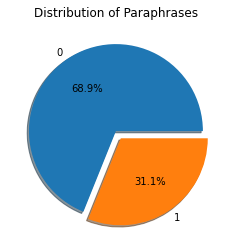

In [ ]:
ax=dev['output'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%' ,shadow=True)
ax.set_title('Distribution of Paraphrases')
ax.set_ylabel('')
plt.show()

paraphrase:  1470
Not paraphrase :  3257


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


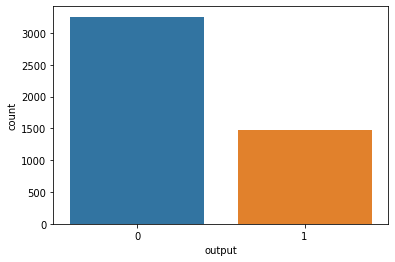

In [ ]:
plot_sb = sb.countplot(dev['output'], label='output')
no, yes  = dev['output'].value_counts()
print('paraphrase: ', yes)
print('Not paraphrase : ', no)

**Helper Functions**

In [ ]:
def getConfusionMatrix(y_test, y_pred):
  # Confusion matrix
  mat = confusion_matrix(y_test, y_pred)
  cm = pd.DataFrame(mat)
  TP = cm.iloc[1,1] # True Positive
  TN = cm.iloc[0,0] # True Negative
  FP = cm.iloc[0,1] # False Positive
  FN = cm.iloc[1,0] # False Negative

  print('Sensitivity: {:.2%}'.format(TP/(FN+TP)))
  print('Specificity: {:.2%}'.format(TN/(FP+TN)))
  
  sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True)
  plt.title('A confusion matrix showing the frequency of misclassifications by our classifier')
  plt.xlabel('true label')
  plt.ylabel('predicted label');
  plt.show()

def overlap(s1,s2):
  s = s1 + s2
  s = set(s)
  if len(s1) > len(s2):
    min_len = len(s2)
  else:
    min_len = len(s1)
  
  if (len(s)/min_len) < 0.8 : return 0
  else: return 1  

In [ ]:
def plotting(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

**Deep Learning Model**

In [ ]:
# merging the two tweets as a single input

train["tweets"] = train["t1"] + train["t2"]
test["tweets"] = test["t1"] + test["t2"]
dev["tweets"] = dev["t1"] + dev["t2"]

train_X = train['tweets']
train_y = train['output']

val_X = dev['tweets']
val_y = dev['output']

test_X = test['tweets']
test_y = test['output']

In [ ]:
max_features = 50000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 500 # max number of words in a question to use


In [ ]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
val_X = tokenizer.texts_to_sequences(val_X)
test_X = tokenizer.texts_to_sequences(test_X)

In [ ]:
train_X = pad_sequences(train_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)
val_X = pad_sequences(val_X, maxlen=maxlen)

In [ ]:
S_DROPOUT = 0.4
DROPOUT = 0.1

In [ ]:
embed_size = 200

In [ ]:
from numpy import asarray
# load the whole embedding into memory
embeddings_index = dict()
f = open('glove.twitter.27B.200d.txt', encoding="utf8")
for line in f:
  values = line.split()
  word = values[0]
  coefs = asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

In [ ]:
from numpy import zeros
# create a weight matrix for words in training data
embedding_matrix = zeros((max_features, embed_size))
for word, i in tokenizer.word_index.items():
  if i >= max_features: continue
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [ ]:
#defining the model
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 500, 200)          10000000  
_________________________________________________________________
bidirectional (Bidirectional (None, 500, 128)          135680    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                2064      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17    

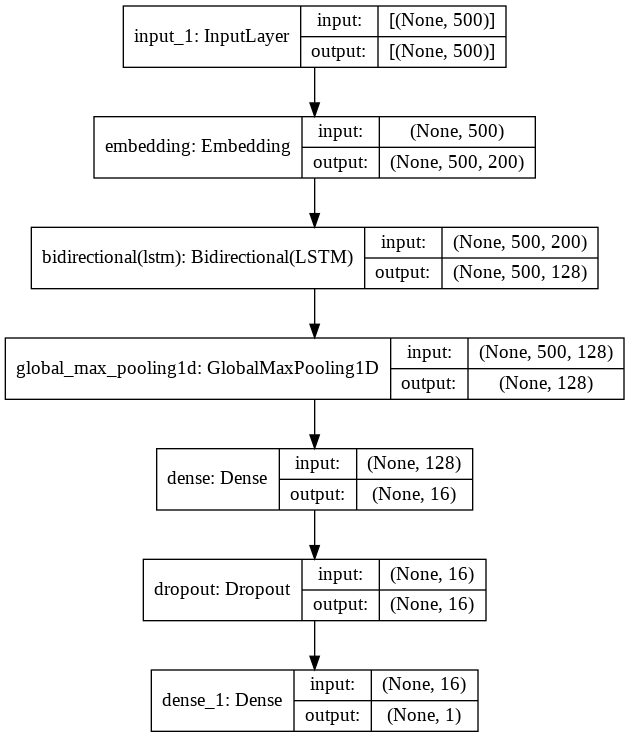

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
X_resampled, y_resampled = train_X, train_y

In [ ]:
#training the model
history = model.fit(X_resampled, y_resampled, batch_size=512, epochs=10, validation_data=(val_X, val_y))

Epoch 1/10
26/26 [==============================] - 186s 7s/step - loss: 0.6295 - accuracy: 0.6480 - val_loss: 0.6146 - val_accuracy: 0.6899
Epoch 2/10
26/26 [==============================] - 171s 7s/step - loss: 0.5509 - accuracy: 0.7083 - val_loss: 0.6596 - val_accuracy: 0.6909
Epoch 3/10
26/26 [==============================] - 171s 7s/step - loss: 0.4861 - accuracy: 0.7716 - val_loss: 0.7150 - val_accuracy: 0.6890
Epoch 4/10
26/26 [==============================] - 188s 7s/step - loss: 0.4163 - accuracy: 0.8198 - val_loss: 0.8489 - val_accuracy: 0.6922
Epoch 5/10
26/26 [==============================] - 174s 7s/step - loss: 0.3534 - accuracy: 0.8518 - val_loss: 0.9176 - val_accuracy: 0.6884
Epoch 6/10
26/26 [==============================] - 174s 7s/step - loss: 0.2932 - accuracy: 0.8837 - val_loss: 1.0278 - val_accuracy: 0.6833
Epoch 7/10
26/26 [==============================] - 173s 7s/step - loss: 0.2090 - accuracy: 0.9246 - val_loss: 1.1976 - val_accuracy: 0.6810
Epoch 8/10
26

KeyError: ignored

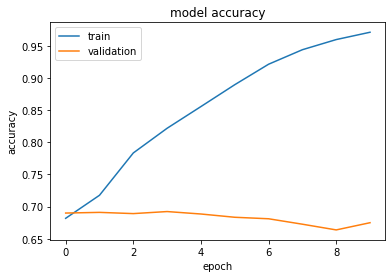

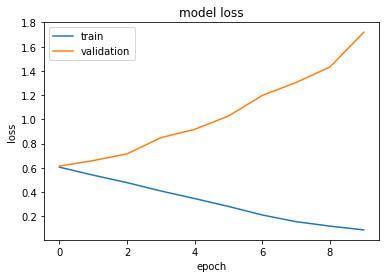

In [ ]:
plotting(history)

In [ ]:
test_y = test_y.apply(lambda x :binary(x) )

In [ ]:
test_y.head()

0    1
1    0
2    0
3    0
4    0
Name: output, dtype: int64

In [ ]:
# prediction on test data
loss, acc = model.evaluate(test_X, test_y, verbose=0)
print('Test Accuracy: %f' % (acc*100))

Test Accuracy: 64.917696


In [ ]:

pred_test_y = model.predict([test_X], batch_size=1024, verbose=1)
pred_test_y = (pred_test_y > 0.5).astype(int)

unique, counts = np.unique(pred_test_y, return_counts=True)
print(np.asarray((unique, counts)).T)

1/1 [==============================] - 4s 4s/step
[[  0 892]
 [  1  80]]


Sensitivity: 7.77%
Specificity: 91.55%


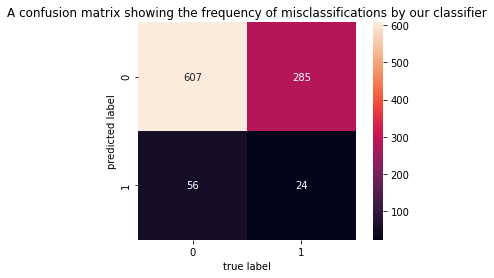

In [ ]:
getConfusionMatrix(test_y, pred_test_y)

In [ ]:

print(f1_score(pred_test_y, test_y, average="macro"))
print(precision_score(pred_test_y, test_y, average="macro"))
print(recall_score(pred_test_y, test_y, average="macro"))

0.4520503558468825
0.4966026739299155
0.4902466367713004
